<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

**Задача данных**

Построить модель со значением метрики качества *F1* не меньше 0.75. 

## Подготовка

In [1]:
!python3 -m pip install --upgrade scikit-learn 
!pip install TextBlob
!pip install wordcloud 
!pip3 install --upgrade Pillow==9.2.0
!pip3 install wget

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
#os._exit(00) #елси надо рестатртнуть ядро

import re 
import warnings
from datetime import datetime
from PIL import ImageFont
from wget import download

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from textblob import TextBlob

from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer

from catboost import CatBoostClassifier

import pickle
from wordcloud import WordCloud

In [3]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', 300)

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
#обновим список стоп слов библиотеки nltk
nltk.download('stopwords')

[nltk_data] Error loading punkt: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno -2] Name or service not known>
[nltk_data] Error loading stopwords: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


False

In [4]:
def read_csv(index_col=[0]):
    """
    Функция загружает данные из csv
    """
    path_my = '/home/oslik/Yandex_curs_DS/Project_s3_4/datasets/toxic_comments.csv'
    path_ya = '/toxic_comments.csv'
    get_http = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'
    
    try:
        if os.path.exists(path_my):
            data_read_csv = pd.read_csv(
                path_my,
                index_col = index_col if index_col else None 
            )
        elif os.path.exists(path_ya):
            data_read_csv = pd.read_csv(
                path_ya,
                index_col = index_col if index_col else None
            )
        else: 
            raise FileNotFoundError  
    
    except FileNotFoundError:
        try:
            data_read_csv = pd.read_csv(
                get_http,
                index_col = index_col if index_col else None
            )
        except:
            print('file and url not found')
    return data_read_csv if data_read_csv.shape[0] else None

In [5]:
def del_stop_words(text):
    '''функция очистки текста от стоп-слов'''
    #words = TextBlob(text)
    return " ".join(set(TextBlob(text).words).difference(set(stopwords.words('english'))))


In [6]:
def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)


In [7]:
def get_text(data, col_name):
    """
    Принимает на вход строку, оставляет пробелы и апостраф
    возвращает лемматизированную строку
    """
    result = del_stop_words(' '.join(
        re.sub(
            r'[^a-z \n]',
            '',
            data[col_name].lower()
        ).split()
    ))
    result = lemmatize_with_postag(result)
    #result = lemmatize_with_postag(
    #    ' '.join(
    #        re.sub(
    #            r'[\n]',
    #            ' ',
    #            data[col_name].lower()
    #        ).split()
    #    ))
    #" ".join([token.lemma_ for token in result])
    return result

In [8]:
def get_pie_plt(data):
    data.value_counts().plot(kind='pie', autopct='%.2f%%', figsize=(10,5));
    plt.title('Распределение ключевых признаков');
    plt.show()

In [9]:
def model_func(model,
               X: pd.DataFrame,
               y: pd.Series,
               param_grid:dict=dict(),
               random_state=None,
               name_data:str='f1_train',
               #cv=TimeSeriesSplit(n_splits=2),
               cv=3,):


    model = model(**random_state) if random_state else model()
    pipe = Pipeline([
        #('vect', CountVectorizer(stop_words=('english'))),
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', model)])  

    gs_ridge = GridSearchCV(
        pipe, 
        param_grid=param_grid, 
        scoring=make_scorer(f1_score),
        cv=cv,
    )
                   
    all_time = datetime.now()
    gs_ridge.fit(X, y)
    all_time = (datetime.now() - all_time)
    best_model = gs_ridge.best_estimator_
    best_param = gs_ridge.best_params_
    gs_ridge.verbose
                   
    data = {
        'name': [model.__class__()],
        name_data: [abs(gs_ridge.best_score_),],
        #'best_model': [f'{best_model=}',],
        'best_param': [f'{best_param=}',],
        'all_time_sec': [f'{all_time.total_seconds()}',],
        #'model': [f'model={model}',],
        'bin_':[pickle.dumps(gs_ridge)]
    }
    return pd.DataFrame(data)

Получим и посмотрим на данные

In [10]:
data_read_csv = read_csv()

Посмотрим на данные

In [11]:
data_read_csv

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no...",0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0
...,...,...
159446,""":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you feel? You can't even give a consistent argument - is the opening only supposed to mention significant aspects, or the """"most significant"""" ones? \n\n""",0
159447,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61.19.93,0
159448,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0
159449,And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.,0


In [12]:
data_read_csv.isna().sum()

text     0
toxic    0
dtype: int64

In [13]:
data_read_csv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [14]:
data_read_csv[['text', 'toxic']].duplicated().sum()

0

In [15]:
data_read_csv.toxic.unique()

array([0, 1])

In [16]:
len(data_read_csv.text.unique())

159292

в данных есть 2 интересующих столбца text и toxic.
пропусков и явных дублей нет.

строк - 159292. последний индекс - 159450

сбросим индексы

In [17]:
data_read_csv.reset_index(drop=True, inplace=True)

определим какие коментарии считаются токсичными (0 или 1)

In [18]:
data_read_csv[data_read_csv.toxic==1].sample(5)

,text,toxic
42373,Ian Watkins==\nIt's a realible source. It's a fansite. These people dedicates there lives for these celeberties. Sorry for som incorrect bitch. FUCK YOU. Answeare me ass quick as possible\n\n==,1
18011,"My music is recorded in Salvation Army studio and google my name, is all over google, it obvious that this person here cannot read, and is a psychopath who loves to tramp on other people and their achivements\nYou find nothing on this guy online; YOU ARE A BLOODY LYING BASTARD...\nGrammar, so t...",1
143348,"Virgin\nMy only warning? You'll block me? Well f*ck off. You probably get off from warning people on Wikipedia, don't you? I bet you're still a virgin, f*cking homo. As for your warning, shove it up your ass. and F*CK YOU!",1
84926,""":: Saju's right. You accused Spine-Cleaver of being me? No no my friend, ask an Admin to use an IP Checker rather than out right banning him. You've made a big mistake. This is going down in the books. Fool....hahahha.\n\n-Awliya —Preceding unsigned comment added by 89.108.33.173 \n\n""",1
55012,"I want this jerk blocked for vandalism\n (once again reverting to last good version Beckford's claims that I am not allowed to edit are ridiculous, especially as he is here only to push POV and promote himself and his alleged expert status) \n\n This war will go on forever. He is simply a jerk....",1


определенно коментарии с ключевам полем 1 - "токсичные"

посмотрим на распределение ключевых признаков

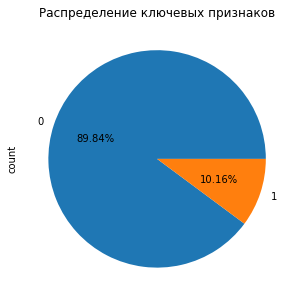

In [19]:
get_pie_plt(data_read_csv.toxic)

In [20]:
f'отношение коментариев токсичных к нетоксичным - \
{(data_read_csv.toxic==1).sum()/(data_read_csv.toxic==0).sum():.2%}'

'отношение коментариев токсичных к нетоксичным - 11.31%'

при обучении надо будет учитывать, что есть такая разница внутри классов. 

очистим комментарии от знаков припинания, оставим только латиницу

затем получим лемматизированные строки и сохраним их в набор.
использовать будем библиотеку textblob

In [21]:
%%time
data_read_csv['lem_text'] = data_read_csv.agg(
    get_text,
    axis=1,
    col_name='text',    
)

CPU times: user 5min 10s, sys: 2.37 s, total: 5min 12s
Wall time: 5min 12s


In [22]:
data_read_csv.sample(10)

,text,toxic,lem_text
147457,"That may be the case, but there is still no ambiguity over the repulsiveness of irish nationalists, who deserved to be shot dead. 79.75.141.101",1,repulsiveness still shot case deserve nationalist dead ambiguity may irish
40232,"Merge Pillow pants \n\nMerge pillow pants into this article, please. It doesn't deserve a seperate article. A lot of movie jokes tend to have articles created then ultimately merge back to the movie's main article. I have redirected it three times and recommended the article's creator to merge i...",0,pant tend merge joke movie remove admin lot anything write please get back thanks ultimately time seperate movie three create tourettesguy main someone reinstate pillow talk refuse recommend agree doesnt deserve article redirect creator page article
47695,"""\n\nOh, I thought that this might have come into play:\n\nOthers' comments\n\nIt is not necessary to bring talk pages to publishing standards, so there is no need to correct typing errors, grammar, etc. It tends to irritate the users whose comments you are correcting. \n\nNever edit someone's ...",0,permission add acceptable wpattackremoval bring oh long correct anything personal preceding must might contribution please etc remove contribs exception topic short edit come interruption others controversial never comment reply word cite libel although form edit format text irritate see general...
157411,"MFI is a self-made cult, which was establish by younas (A former disciple of gohar shahi) who was kicked-out by GS in his life. He (Younas) formed this MFI to take revenge with Gohar Shahi of his exile from ASI and started preaching self-made teachings and linked them to Gohar Shahi. The truth i...",0,life asi disciple kickedout former take ie content government ban cult suggest form revenge g due picture themthis pakistan use provide follow name exile shahi would use start truth blasphyous muhammad preach edit war hopefully wwwgoharshahicom comply option also algohar view three younas refere...
84789,Fine whatever. I'm finished with this shit. Vandals and racists should feel perfectly at home here. That's who is being protected after all. It's all a simple matter of looking at each user's contributions and the various related discussions. More than a few editors have tried dealing with ...,1,resolve life obvious policy various im whatever protect attempt nice dont one vandalized editor ever anything personal admins year simple racist anoshirawan perfectly revertnpovetc deal look thats another discussion shit block try finish related matter behnam home difference ethnicity feel fine ...
139086,"""\n\n Not Criticism \n\nThis is not criticism and doesn't belong in a titled as such\n\n""""This business model has received attention for minimizing the environmental impact of shopping.[18]""""\n\nThat's called praise.""",0,impact environmental minimize praise belong shop criticism business doesnt title attention thats call receive model
9629,"""\n\nPlease add a paragraph where, pronunciation of """"Bangladesh"""" or """"Bangla"""" is done correctly by using regular, commonly used words, which can be understood by most regular foreigners / non-native speakers, very easily. \n-""",0,pronunciation paragraph do word nonnative foreigner easily use speaker please commonly correctly bangladesh add use bangla understood regular
131533,"""\nAgain, there was no """"as if"""" in GTBacchus's statement, nor any """"as if"""" equivalent. GTBacchus maintains that Norton was, indeed, """"an emperor"""". If both you and he now agree that the article's previous use of the word """"emperor"""" was figurative and that Norton had no authority to issue dec...",0,order statement happy anything equivalent word decree utc norton issue authority maintain else indeed emperor use figurative jan clarifies agree gtbacchus previous article gtbacchuss article
139027,"Why do you think it should be included in this article amongst respectable, academic sources?",0,

разделим данные на выборки

от первоначальной выбоки возьмем треть, с сохранением распределения по классам, а то данных очень много

и дропнем индексы

In [23]:
data_train_split, _ = train_test_split(data_read_csv,
                            random_state=12345,
                            stratify=data_read_csv.toxic,
                            train_size=.33)
#data_train_split = data_read_csv
    
train, valid = data_train_split.lem_text, data_train_split.toxic
 
data_tmp = train_test_split(train, valid,
                            random_state=12345,
                            stratify=valid,
                            test_size=.2)
for i in data_tmp:
    i.reset_index(drop=True, inplace=True)
X_train, X_test, y_train, y_test = data_tmp

<font size=4 color="red"> Комментарий студента</font>

<font size=2 color="red"> убрал  функцию разделения

In [24]:
f'отношение трейн и тест {len(X_test)/len(X_train):.1%}'

'отношение трейн и тест 25.0%'

In [25]:
f'размерность трейн - {len(X_train)}, тест - {len(X_test)}'

'размерность трейн - 42052, тест - 10514'

посмотрим на облако слов

100% [........................................................] 275572 / 275572

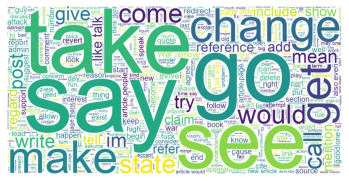

In [27]:
fd = '{}{}{}'.format(
    os.path.abspath('.'),
    os.sep,
    'Arial.ttf')
if not os.path.exists(fd):
    fd = '{}{}{}'.format(
        os.path.abspath('.'),
        os.sep,
        download(
            "https://github.com/matomo-org/travis-scripts/raw/master/fonts/\
Arial.ttf"))

param = {
    'background_color':"white",
    'width': 1200, 'height': 600,
    'stopwords': ' ',
    'max_words': 1000,
    'font_path': fd
}
wc = WordCloud(**param, ).generate(''.join(data_read_csv.lem_text.values))
plt.axis("off")
plt.imshow(wc)
plt.show()
os.remove(fd)

можно приступать к обучению модeли.

модели будем обучать с использованием GridSearchCv через Pipeline, которому передадим CountVectorizer, TfidfTransformer для удаления стоп слов, и векторизаци

при работе над разделом было проведено :
* ознакомление с данными;
* разобраны ключевые признаки;
* произведена очистка данных;
* произведена лемматизация данных
* произведена борьба с дисбалансом классов
  
векторизация и удаление стоп слов будет произведена на следующем этапе.  

## Обучение

создадим таблицу для хранения результатов

In [28]:
data_rouger=pd.DataFrame()

обучим модель LogisticRegression и запишем данные в таблицу

In [ ]:
data_rouger = pd.concat(
    [data_rouger, model_func(
        X=X_train,
        y=y_train,
        model=LogisticRegression,
        random_state={
            'class_weight':'balanced',
            'random_state': 42,
        },
        param_grid={
            'tfidf__sublinear_tf': (True, False),
            'clf__penalty': ['l2', 'l1'],   #l2
            'clf__intercept_scaling': np.arange(.1, 5, 2),
            'clf__C': np.arange(15, 26, 5),
        }
    )],
    axis=0,
    ignore_index=False,
)

In [33]:
features

ColumnTransformer(transformers=[('text_preprocess',
                                 TfidfVectorizer(stop_words=<WordListCorpusReader in '/home/oslik/nltk_data/corpora/stopwords'>),
                                 'lemmatized_text'),
                                ('new_features_preprocess', StandardScaler(),
                                 ['lengh', 'number'])])

обучим модель SGDClassifier и запишем данные в таблицу

In [34]:
data_rouger = pd.concat(
    [data_rouger, model_func(
        X=X_train,
        y=y_train,
        model=SGDClassifier,
        random_state={
            'random_state': 42,
        },
        param_grid={
            'tfidf__smooth_idf': (True, False),
            'tfidf__sublinear_tf': (True, False),
            'tfidf__norm': ['l1','l2'],
            'clf__loss': ['squared_error','log_loss'],
            'clf__penalty': ['l1','l2'],
            'clf__alpha': [1e-05, 1e-04, 1e+03, 1e+04],
            'clf__class_weight': [None, 'balanced']
        }
    )],
    axis=0,
    ignore_index=False,
)

обучим модель DecisionTreeClassifier и запишем данные в таблицу

In [ ]:
data_rouger = pd.concat(
    [data_rouger, model_func(
        X=X_train,
        y=y_train,
        model=DecisionTreeClassifier,
        random_state={
            'random_state': 42,
        },
        param_grid={}
    )],
    axis=0,
    ignore_index=False,
)

обучим модель CatBoostClassifier и запишем данные в таблицу

In [ ]:
data_rouger = pd.concat(
    [data_rouger, model_func(
        X=X_train,
        y=y_train,
        model=CatBoostClassifier,
        random_state={
            'verbose': False,
            'random_state': 42,
        },
        param_grid={
            'clf__iterations':[200,]
        }
    )],
    axis=0,
    ignore_index=False,
)

In [ ]:
data_rouger = data_rouger.sort_values(by='f1_train', ascending=False).reset_index(drop=True)
data_rouger

протестируем полученные модели

In [ ]:
dick={'name':[], 'F1':[]}
model = pickle.loads(data_rouger.loc[0, 'bin_'])
dick['F1'].append(f1_score(model.predict(X_test), y_test))
dick['name'].append(data_rouger['name'].loc[0])

In [ ]:
pd.DataFrame(dick).set_index('name').sort_values(by='F1', ascending=False)

на тестовой выборке показатель F1 соответствует условиям задания

In [ ]:
probabilities = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probabilities[:,1]) 

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(10,10))
ax = plt.plot(fpr, tpr)
ax = plt.plot([0, 1], [0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [ ]:
model.get_feature_names_out().tolist()

In [ ]:
model.coef_.tolist()[0]

## Выводы

В ходе работы над проектом были выполнены этапы:
1. Подготовка, в ходе которой:
   * загружены необходимые библиотеки, подготовлены функции
   * загружены и изучены данные
   * проведена преобработка текста:
   * * очистка текста от пунктуационных символов
     * тексты приведены к нижнему регистру
     * произведена лемматизация текстов
     * данные разделены на выборки
     * выполнена работа по борьбе с дисбалансом классов
3. Обучение моделей:

   * обучены 3 модели (LogisticRegression, SGDClassifier, DecisionTreeClassifier , CatBoostClassifier) с использованием GridSearchCv через Pipeline, которому передавался CountVectorizer, TfidfTransformer для удаления стоп слов, и векторизаци
   * получены метрики, на основании которых была определена лучшая модель
   * проведено тестирование лучшей модели
   * постороена матрица ошибок

    В SGDClassifier при тестировании достугнут целевой уровень метрики F1.

    Итоговый показатель F1 составил - 0.764278.
